# Statistics in `cytoflow`

One of the most powerful concepts in `cytoflow` is that it makes it easy to summarize subsets of your data, then track how those subsets change as your experimental variables change.  This notebook demonstrates several different modules that create and plot statistics.

---

Set up the Jupyter `matplotlib` integration, and import the `cytoflow` module.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import cytoflow as flow

We use the same data set as the **Yeast Dose Response** example notebook, with one variant: we load each tube three times, grabbing only 100 events from each.

In [2]:
inputs = {
    "Yeast_B1_B01.fcs" : 5.0,
    "Yeast_B2_B02.fcs" : 3.75,
    "Yeast_B3_B03.fcs" : 2.8125,
    "Yeast_B4_B04.fcs" : 2.109,
    "Yeast_B5_B05.fcs" : 1.5820,
    "Yeast_B6_B06.fcs" : 1.1865,
    "Yeast_B7_B07.fcs" : 0.8899,
    "Yeast_B8_B08.fcs" : 0.6674,
    "Yeast_B9_B09.fcs" : 0.5,
    "Yeast_B10_B10.fcs" : 0.3754,
    "Yeast_B11_B11.fcs" : 0.2816,
    "Yeast_B12_B12.fcs" : 0.2112,
    "Yeast_C1_C01.fcs" : 0.1584,
    "Yeast_C2_C02.fcs" : 0.1188,
    "Yeast_C3_C03.fcs" : 0.0892,
    "Yeast_C4_C04.fcs" : 0.0668,
    "Yeast_C5_C05.fcs" : 0.05,
    "Yeast_C6_C06.fcs" : 0.0376,
    "Yeast_C7_C07.fcs" : 0.0282,
    "Yeast_C8_C08.fcs" : 0.0211,
    "Yeast_C9_C09.fcs" : 0.0159
}

tubes = []
for filename, ip in inputs.iteritems():
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 1}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 2}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 3}))

    
ex = flow.ImportOp(conditions = {'IP' : "float", "Replicate" : "int"},
                   tubes = tubes,
                   coarse_events = 100).apply()

In `cytoflow`, a *statistic* is a value that summarizes something about a subset of the data.  For example, if we expect the geometric mean of `FITC-A` channel to change as the `IP` variable changes, we can compute those geometric means with the `Statistics1DOp` operation:

In [3]:
op = flow.Statistics1DOp(name = "ByIP",
                         by = ["IP"],
                         channel = "FITC-A",
                         function = flow.geom_mean)
ex2 = op.apply(ex)

This operation splits the data set by different values of `IP`, then applies the function `flow.geom_mean` to the `FITC-A` channel in each subset.  The result is stored in the `statistics` attribute of the `Experiment` that it returns:

In [4]:
ex2.statistics

{('ByIP', 'geom_mean'): IP
 0.0159     114.590020
 0.0211     152.676554
 0.0282     158.255147
 0.0376     191.279962
 0.0500     256.193858
 0.0668     404.191516
 0.0892     644.715182
 0.1188    1015.472264
 0.1584    1253.581463
 0.2112    1131.254262
 0.2816    1495.816232
 0.3754    1677.356571
 0.5000    1795.486173
 0.6674    2316.729691
 0.8899    2328.402821
 1.1865    2429.482022
 1.5820    2294.332816
 2.1090    2394.283948
 2.8125    2432.385118
 3.7500    2557.903710
 5.0000    2292.077890
 Name: FITC-A, dtype: float64}

The `statistics` attribute is a dictionary.  The keys are tuples, where the first element in the tuple is the name of the operation that created the statistic, and the second element is specific to the operation.  The `Statistics1DOp` operation sets the second element of the tuple to the function name.  (You can override this by setting `Statistics1DOp.statistic_name`; this is useful if `function` is a lambda function.)

In [5]:
ex2.statistics.keys()

[('ByIP', 'geom_mean')]

The value of each entry in `Experiment.statistics` is a `pandas.Series`.  The series index is all the subsets for which the statistic was computed, and the contents are the values of the statstic itself.

In [6]:
ex2.statistics[('ByIP', 'geom_mean')]

IP
0.0159     114.590020
0.0211     152.676554
0.0282     158.255147
0.0376     191.279962
0.0500     256.193858
0.0668     404.191516
0.0892     644.715182
0.1188    1015.472264
0.1584    1253.581463
0.2112    1131.254262
0.2816    1495.816232
0.3754    1677.356571
0.5000    1795.486173
0.6674    2316.729691
0.8899    2328.402821
1.1865    2429.482022
1.5820    2294.332816
2.1090    2394.283948
2.8125    2432.385118
3.7500    2557.903710
5.0000    2292.077890
Name: FITC-A, dtype: float64

We can also specify multiple variables to break data set into.  In the example above, `Statistics1DOp` lumps all events with the same value of `IP` together, but each amount of `IP` actually has three values of `Replicate` as well.  Let's apply `geom_mean` to each unique combination of `IP` and `Replicate`:

In [7]:
op = flow.Statistics1DOp(name = "ByIP",
                         by = ["IP", "Replicate"],
                         channel = "FITC-A",
                         function = flow.geom_mean)
ex2 = op.apply(ex)
ex2.statistics[("ByIP", "geom_mean")][0:12]

IP      Replicate
0.0159  1            118.510134
        2            108.239427
        3            117.300378
0.0211  1            156.535552
        2            157.671755
        3            144.194984
0.0282  1            160.248120
        2            168.601945
        3            146.695910
0.0376  1            181.958079
        2            207.649571
        3            185.227749
Name: FITC-A, dtype: float64

Note that the `pandas.Series` now has a `MultiIndex`: there are values for each unique combination of `IP` and `Replicate`.

---

Now that we have computed a statistic, we can plot it with one of the statistics views.  We can use a bar chart:

In [8]:
flow.BarChartView(statistic = ("ByIP", "geom_mean"),
                  variable = "IP").plot(ex2)

CytoflowViewError: Must use all the statistic indices as variables or facets: [u'IP', u'Replicate']

Oops!  Whenever we plot a statistic, we have to use *all* of the variables that were used to subdivide the experiment.  If the `Statistics1DOp` above had `by = ["IP", "Replicate"]`, then both `IP` and `Replicate` must either a plot variable or a plot facet.  Let's try it again:

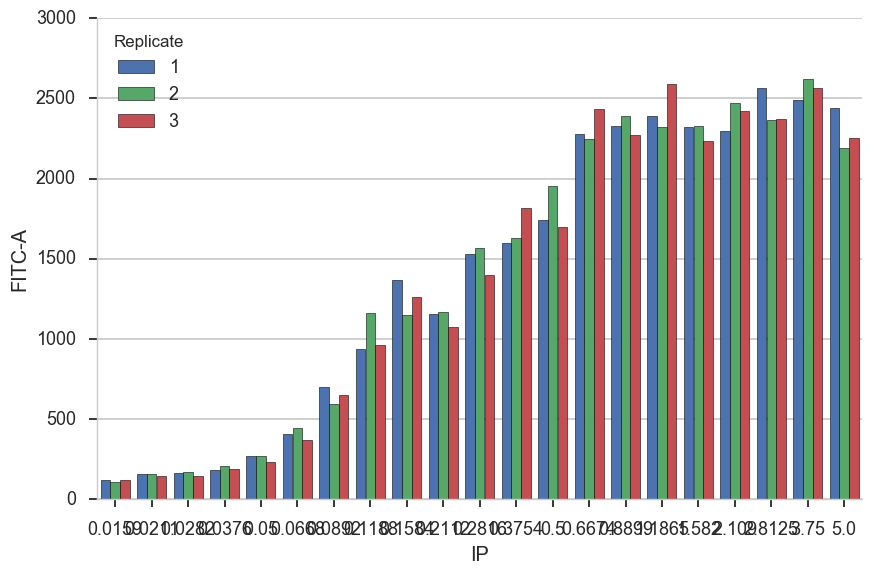

In [9]:
flow.BarChartView(statistic = ("ByIP", "geom_mean"),
                  variable = "IP",
                  huefacet = "Replicate").plot(ex2)

Bar charts are really best for categorical variables (with a modest number of categories.)  Let's do a line chart instead:

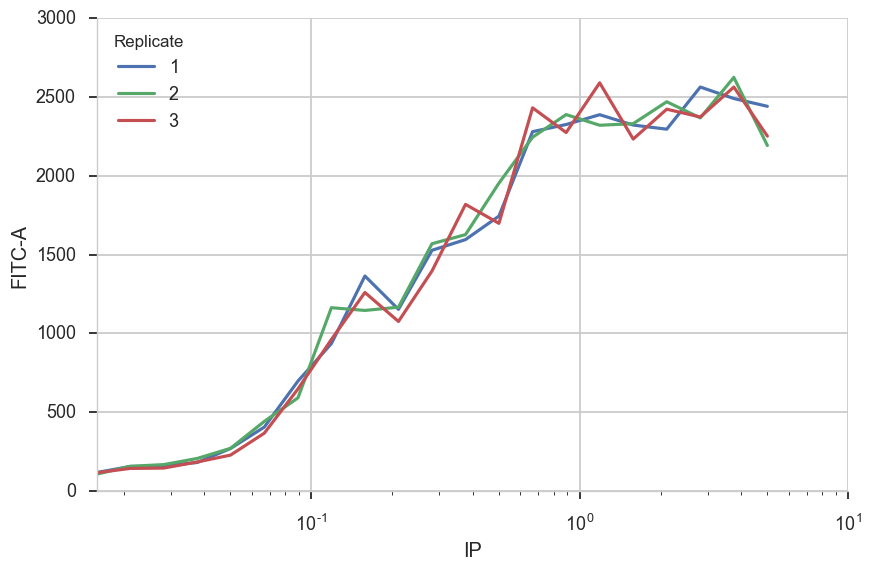

In [10]:
flow.Stats1DView(statistic = ("ByIP", "geom_mean"),
                 xvariable = "IP",
                 xscale = 'log',
                 huefacet = "Replicate").plot(ex2)

Statistics views can also plot error bars; the error bars must *also* be a statistic, and they must have the same indices as the "main" statistic.  For example, let's plot the geometric mean and geometric standard deviation of each IP subset:

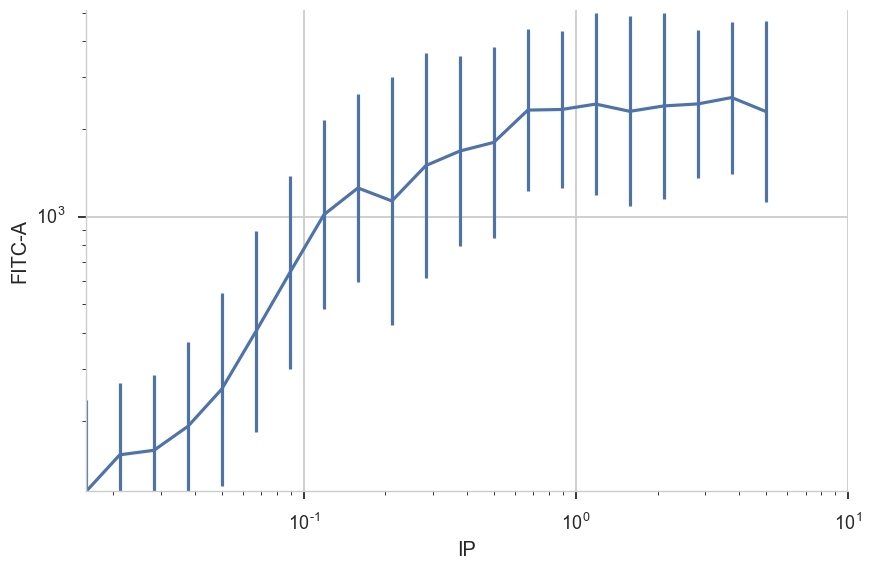

In [14]:
ex2 = flow.Statistics1DOp(name = "ByIP",
                          by = ["IP"],
                          channel = "FITC-A",
                          function = flow.geom_mean).apply(ex)

ex3 = flow.Statistics1DOp(name = "ByIP",
                          by = ['IP'],
                          channel = "FITC-A",
                          function = flow.geom_sd_range).apply(ex2)

flow.Stats1DView(statistic = ("ByIP", "geom_mean"),
                 xvariable = "IP",
                 xscale = "log",
                 yscale = "log",
                 error_statistic = ("ByIP", "geom_sd_range")).plot(ex3)

The plot above 

2120.39038022
2.29714505847
101.813344816


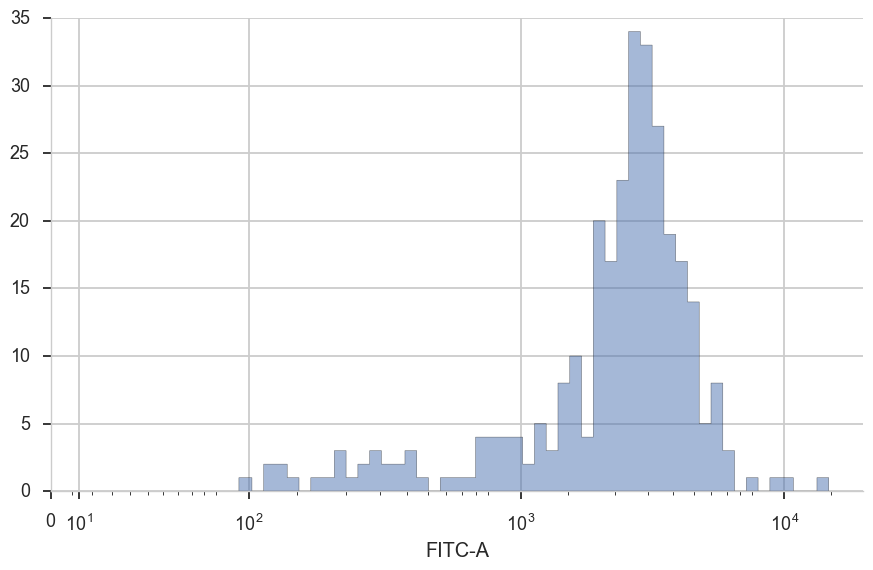

In [15]:
flow.HistogramView(subset = "IP == 5", channel = "FITC-A", scale = "logicle").plot(ex)
print flow.geom_mean(ex.data.query("IP == 5")["FITC-A"])
print flow.geom_sd(ex.data.query("IP == 5")["FITC-A"])
print flow.geom_sem(ex.data.query("IP == 5")["FITC-A"])

Now, let's get what we came for: a dose-response curve.  The `Stats1DView` view subsets the experiment by the metadata field specified in `variable` (in this case the "IP" variable) and then applies `yfunction` to each subset.  `yfunction` must be a function that takes a single list-like argument and returns a single float; it is applied to the `ychannel` channel of each subset.  In this case, the distributions are (approximately!) log-normally distributed, so let's use a geometric mean as a measure of center.

Again, remember to specify the subset we're interested in: cells that we don't think were debris.

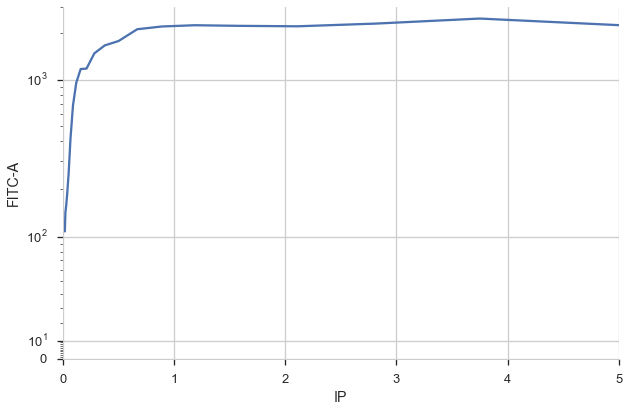

In [8]:
flow.Stats1DView(xvariable = "IP",
                 ychannel = "FITC-A",
                 yfunction = flow.geom_mean,
                 subset = "Debris_Filter == True").plot(ex2)

Oops!  The IP concentration was on a log scale; let's re-scale that axis.

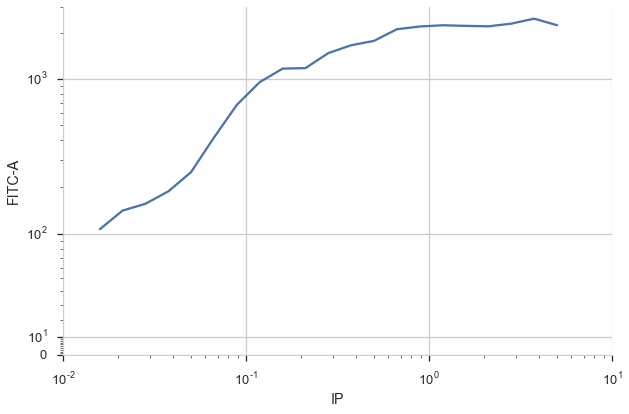

In [9]:
flow.Stats1DView(xvariable = "IP",
                 xscale = "log",
                 ychannel = "FITC-A",
                 yfunction = flow.geom_mean,
                 subset = "Debris_Filter == True").plot(ex2)

And of course, because the underlying data is just a `pandas.DataFrame`, we can manipulate it with the rest of the Scientific Python ecosystem.  Here, we get the actual geometric means in a table that we can manipulate further, using `pandas.DataFrame.groupby`.

In [10]:
(ex2.data.query("Debris_Filter == True")[['IP', 'FITC-A']]
         .groupby('IP')
         .agg(flow.geom_mean))

,FITC-A
IP,
0.0159,108.111191
0.0211,141.999116
0.0282,157.140483
0.0376,188.344775
0.0500,249.401844
0.0668,416.628259
0.0892,680.410392
0.1188,955.793469
0.1584,1172.023941
